# Project work

In [274]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

np.seterr(over='ignore')

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

### Utility functions

In [275]:
# Evaluate the difficulty of each problem
def evaluate_problem_difficulty(problems):
    difficulty_scores = []
    
    for i, problem in enumerate(problems):
        X, y, variables = problem["X"], problem["y"], problem["variables"]
        num_vars = len(variables)  
        num_samples = X.shape[1]  
        variability = np.std(y)  
        difficulty = (num_vars * 2) + (num_samples / 5000) + (variability / (np.median(y) + 1e-8))
        difficulty_scores.append((i + 1, difficulty, X, y, variables))
    return difficulty_scores

In [276]:
problems = []
for i in range(1,9):
  data = np.load(f"data/problem_{i}.npz")
  X = data['x']
  y = data['y']
  num_vars = X.shape[0]
  variables = [f"x{i}" for i in range(num_vars)]
  problems.append({"X": X, "y": y, "variables": variables})

difficulty_ranking = evaluate_problem_difficulty(problems)

for problem_id, score, X, y, variables in difficulty_ranking:
    print(f"Problem {problem_id}: X = {X.shape}, y = {y.shape}, variables = {variables}, Difficulty Score = {score:.2f}")

Problem 1: X = (1, 500), y = (500,), variables = ['x0'], Difficulty Score = -6.51
Problem 2: X = (3, 5000), y = (5000,), variables = ['x0', 'x1', 'x2'], Difficulty Score = 50.01
Problem 3: X = (3, 5000), y = (5000,), variables = ['x0', 'x1', 'x2'], Difficulty Score = 9.61
Problem 4: X = (2, 5000), y = (5000,), variables = ['x0', 'x1'], Difficulty Score = 8.77
Problem 5: X = (2, 5000), y = (5000,), variables = ['x0', 'x1'], Difficulty Score = 5.23
Problem 6: X = (2, 5000), y = (5000,), variables = ['x0', 'x1'], Difficulty Score = 3.98
Problem 7: X = (2, 5000), y = (5000,), variables = ['x0', 'x1'], Difficulty Score = 14.22
Problem 8: X = (6, 50000), y = (50000,), variables = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5'], Difficulty Score = 6.30


### Node class

In [277]:
# Node class for expressing trees
class Node:
    """ Represents a single node in the expression tree """
    def __init__(self, data, children=None):
        self.data = data  # Operator, variable, or constant
        self.children = children if children else []
    
    def evaluate(self, variables):
        """ Evaluates the mathematical expression represented by the tree """
        if isinstance(self.data, (int, float)):
            return self.data  # Constant value
        elif isinstance(self.data, str):
            return variables[self.data]  # Variable lookup
        elif callable(self.data):
            with np.errstate(all='ignore'):
                try:
                    if len(self.children) == 1:
                        return self.data(self.children[0].evaluate(variables))
                    elif len(self.children) == 2:
                        return self.data(self.children[0].evaluate(variables),
                                        self.children[1].evaluate(variables))
                except (FloatingPointError, ValueError, ZeroDivisionError):
                    return float('inf')  # Penalize invalid expressions

    def to_formula(self):
        """ Returns a human-readable formula representation of the expression tree"""
        if isinstance(self.data, (int, float)):
            return str(round(self.data, 2))
        if isinstance(self.data, str):
            return self.data  # Variable name
        if callable(self.data):
            if len(self.children) == 1:
                return f"{UNARY_SYMBOLS.get(self.data, '?')}({self.children[0].to_formula()})"
            elif len(self.children) == 2:
                return f"({self.children[0].to_formula()} {OP_SYMBOLS.get(self.data, '?')} {self.children[1].to_formula()})"
        return "?"
    
    def extract_variables(self):
        """ Extracts variables used in the expression tree """
        if isinstance(self.data, str):  # If the node is a variable
            return [self.data]
        elif isinstance(self.data, (int, float)):
            return []  # Constants do not contain variables
        else:
            variables = []
            for child in self.children:
                variables.extend(child.extract_variables())
            return variables

### Handling Math Operators

In [278]:
# Protected mathematical operations
#Prevent division by zero
def protected_div(x, y):
    return np.divide(x, y + 1e-6)  
#Avoid log(0) or negative numbers
def protected_log(x):
    return np.log(np.abs(x) + 1e-6)
#Ensure sqrt of non-negative values
def protected_sqrt(x):
    return np.sqrt(np.abs(x))

# Define available operators
BINARY_OPS = [np.add, np.subtract, np.multiply, protected_div, np.power]
UNARY_OPS = [np.sin, np.cos, np.tan, protected_log, np.exp, protected_sqrt, np.abs]

# Operator symbol mapping for better readable expressions
OP_SYMBOLS = {np.add: '+', np.subtract: '-', np.multiply: '*', protected_div: '/', np.power: '^'}
UNARY_SYMBOLS = {np.sin: 'sin', np.cos: 'cos', np.tan: 'tan', protected_log: 'log',
                 np.exp: 'exp', protected_sqrt: 'sqrt', np.abs: 'abs'}

### Calculate fitness

In [279]:
#*********************************** Fitness Function
def calculate_fitness(individual, variables, X, y, penalty=4.5):
    try:
        y_pred = np.array([individual.evaluate(dict(zip(variables, x))) for x in X.T])
        if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
            return float('inf')  # Penalize invalid expressions
        used_variables = set(individual.extract_variables())
        #Add complexity if not all variables are used
        complexity_penalty = penalty * (len(variables) - len(used_variables)) if len(used_variables) < len(variables) else 0
        return np.mean((y - y_pred) ** 2) + complexity_penalty
    except (FloatingPointError, ValueError, TypeError):
        return float('inf')


### Generate random trees

In [280]:
def generate_random_tree(max_depth, variables, depth=0, method='grow'):
    """Recursively generates a random expression tree with controlled depth"""
    
    constant_prob = 0.4

    if depth >= max_depth or (depth > 0 and random.random() < 0.2):
        if random.random() < 0.7:
            return Node(random.choice(variables))  #variable node
        else:
            return Node(round(random.uniform(-10, 10), 2))  #random constant node between -10 and 10
    
    # If method is 'full', generate fully-grown trees
    if method == 'full':
        if random.random() < 0.5:
            op = random.choice(UNARY_OPS)
            return Node(op, [generate_random_tree(max_depth, variables, depth + 1, method='full')])
        else:
            op = random.choice(BINARY_OPS)
            if random.random() < constant_prob:
                #Randomly decide which child will be a constant
                if random.random() < 0.5:
                    #Left child is a constant
                    left_child = Node(random.uniform(-10, 10))  
                    right_child = generate_random_tree(max_depth, variables, depth + 1, method='full')  
                else:
                    #Right child is a constant
                    left_child = generate_random_tree(max_depth, variables, depth + 1, method='full')  
                    right_child = Node(random.uniform(-10, 10))  
            else:
                #No constants
                left_child = generate_random_tree(max_depth, variables, depth + 1, method='full')
                right_child = generate_random_tree(max_depth, variables, depth + 1, method='full')

            return Node(op, [left_child, right_child])
    
    # If method is 'grow', generate trees with variable depth
    elif method == 'grow':
        if random.random() < 0.5:
            op = random.choice(UNARY_OPS)
            return Node(op, [generate_random_tree(max_depth, variables, depth + 1, method='grow')])
        else:
            op = random.choice(BINARY_OPS)
            
            if random.random() < constant_prob:
                if random.random() < 0.5:
                    #Left child is a constant
                    left_child = Node(random.uniform(-10, 10))  
                    right_child = generate_random_tree(max_depth, variables, depth + 1, method='grow')  
                else:
                    #Right child is a constant
                    left_child = generate_random_tree(max_depth, variables, depth + 1, method='grow')  
                    right_child = Node(random.uniform(-10, 10))  
            else:
                #No constants
                left_child = generate_random_tree(max_depth, variables, depth + 1, method='grow')
                right_child = generate_random_tree(max_depth, variables, depth + 1, method='grow')

            return Node(op, [left_child, right_child])
        
    # If method is 'half_and_half', mix 'full' and 'grow' methods
    elif method == 'half_and_half':
        if random.random() < 0.6:
            return generate_random_tree(max_depth, variables, depth, method='full')
        else:
            return generate_random_tree(max_depth, variables, depth, method='grow')


### Generate population

In [281]:
def generate_population(pop_size, max_depth, variables, method='half_and_half'):
    """Generates an initial population of random expression trees."""
    return [generate_random_tree(max_depth, variables, method=method) for _ in range(pop_size)]

### Evolutionary operators

In [282]:
#*************************************** Parent Selection
def tournament_selection(population, fitness_dict, tournament_size):
    """Tournament selection to choose parents for crossover and mutation"""
    tournament = random.sample(population, tournament_size)  
    winner = min(tournament, key=lambda ind: fitness_dict[ind])
    return winner

#*************************************** Mutation

def mutate(node, variables, generation, max_depth=3, agressive_rate=0.7, top=30):
    #Mutates a node in the tree, adjusting mutation intensity over generations
    if generation >= top:
        agressive_rate = max(0.1, agressive_rate * 0.5)  # Reduce mutation in later generations
    else:
        agressive_rate = min(1.0, agressive_rate * 1.2)  # Increase mutation in early generations
    
    if random.random() < agressive_rate:
        if isinstance(node.data, str):
            node.data = random.choice(variables)  # Change variable
        elif isinstance(node.data, (int, float)):
            node.data *= random.uniform(0.5, 1.5)  # Perturb numeric values
        elif callable(node.data):
            node.data = random.choice(UNARY_OPS if len(node.children) == 1 else BINARY_OPS)
    
    if node.children and generation < top and random.random() < agressive_rate:
        if random.random() < 0.5:
            return copy.deepcopy(generate_random_tree(max_depth, variables))  # Replace subtree
    
    for i in range(len(node.children)):
        node.children[i] = mutate(node.children[i], variables, generation, max_depth, agressive_rate, top)
    
    return node

"""
def mutate(node, variables, max_depth=3, mutation_rate=0.2):
   

    # Mutation is now only controlled by the mutation_rate argument
    if random.random() < mutation_rate:
        if isinstance(node.data, str):
            node.data = random.choice(variables)  # Change variable
        elif isinstance(node.data, (int, float)):
            node.data *= random.uniform(0.5, 1.5)  # Perturb numeric values
        elif callable(node.data):
            node.data = random.choice(UNARY_OPS if len(node.children) == 1 else BINARY_OPS)
    
    if node.children and random.random() < mutation_rate:
        if random.random() < 0.5:
            return copy.deepcopy(generate_random_tree(max_depth, variables))  # Replace subtree
    
    for i in range(len(node.children)):
        node.children[i] = mutate(node.children[i], variables, max_depth, mutation_rate)
    
    return node
"""


#*************************************** Crossover
def crossover(parent1, parent2):
    """ Swaps a subtree from parent1 with a subtree from parent2. """
    child1, child2 = copy.deepcopy(parent1), copy.deepcopy(parent2)
    node1, node2 = random.choice(child1.children), random.choice(child2.children)
    node1.data, node2.data = node2.data, node1.data
    node1.children, node2.children = node2.children, node1.children
    return child1

### Evoluation process

In [283]:
def evolve(population, epochs, X, y, variables, depth=3, cross_prob=0.7,tournament_size = 8, penalty=4.5):
    """Runs the genetic programming evolution process"""
    
    fitness_history = []
    #Counter for epochs with no improvement in fitness
    no_improvement_count = 0 
    #Counter for epochs with no significant change in the best fitness 
    no_change = 0  

    #Calculate the initial fitness for all individuals and store it
    fitness_dict = {ind: calculate_fitness(ind, variables, X, y, penalty) for ind in population}
    
    best_individual = min(fitness_dict, key=fitness_dict.get)
    best_fitness = fitness_dict[best_individual]

    fitness_history.append(best_fitness)

    #Evolving the population over multiple generations
    for gen in tqdm(range(epochs), desc="Evolving Generations"):

        #Elitism: Select the best individuals to carry over to the new generation
        sorted_population = sorted(fitness_dict.keys(), key=lambda ind: fitness_dict[ind])
        elite_size = max(1, len(population) // 10)  #Keep top 10% as elites
        new_population = sorted_population[:elite_size]  #Keep the best individuals

        while len(new_population) < len(population):
            if random.random() < cross_prob:  
                #Crossover: Select two parents using tournament selection
                p1 = tournament_selection(sorted_population[:len(population)//2], fitness_dict, tournament_size)
                p2 = tournament_selection(sorted_population[:len(population)//2], fitness_dict, tournament_size)
                offspring = crossover(p1, p2)
            else:  
                #Mutation: Select one parent using tournament selection
                p = tournament_selection(sorted_population[:len(population)//2], fitness_dict, tournament_size)
                offspring = mutate(p, variables, depth)

            new_population.append(offspring)

        #Calculate fitness for the new individuals (excluding elite individuals)
        fitness_dict = {ind: (fitness_dict[ind] if ind in sorted_population[:elite_size] else calculate_fitness(ind, variables, X, y, penalty)) for ind in new_population}

        #Identify the current best individual and its fitness
        current_best = min(fitness_dict, key=fitness_dict.get)
        current_best_fitness = fitness_dict[current_best]

        #Update the best individual if there is an improvement in fitness
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_individual = copy.deepcopy(current_best)
            no_improvement_count = 0
            no_change = 0
        else:
            no_improvement_count += 1
            no_change += 1

        fitness_history.append(best_fitness)

        
        formula = best_individual.to_formula() if best_individual else "N/A"
        print(f"Generation {gen}: Best fitness = {best_fitness}, Formula: {formula}")

        #Adapt crossover and mutation probabilities if no improvement for 10 generations
        if no_improvement_count >= 10:
            no_improvement_count = 0
            cross_prob = max(0.4, cross_prob - 0.05)
            print(f"Adapting parameters: Less Crossover = {cross_prob}, more mutation")

        #Regenerate the population for diversity if there are no significant changes for 6 generations
        if no_change >= 6:
            print("Regenerating population for diversity!")
            new_population = generate_population(len(population), depth, variables)
            new_population.append(best_individual)  #Mantain the best individual
            cross_prob = min(0.7, cross_prob + 0.05) #bring back crossover probability
            no_change = 0

        # Update the population for the next generation
        population = new_population

    return best_individual, best_fitness, fitness_history

### Settings

In [306]:
penalties = [1.5, 5e12, 500, 5.5, 0.05, 5.5, 5.5, 500_000]
pop_sizes = [50, 200, 100, 150, 100, 100, 150, 100]
tournament_sizes = [5, 10, 10, 10, 10, 10, 10, 10]
epochs_list = [30, 100, 100, 100, 50, 100, 100, 50]
max_depths = [3, 5, 5, 7, 4, 5, 5, 4]
methods_pop = ['grow', 'full', 'full', 'half-and-half', 'full', 'half-and-half', 'full', 'full']
cross_prob = 0.8

## Problem 1

Shape di X: (1, 500)
Shape di y: (500,)
Variales: ['x0']



Evolving Generations:   0%|          | 0/30 [00:00<?, ?it/s]

Generation 0: Best fitness = 0.0, Formula: sin(x0)


Evolving Generations:  13%|█▎        | 4/30 [00:00<00:01, 15.23it/s]

Generation 1: Best fitness = 0.0, Formula: sin(x0)
Generation 2: Best fitness = 0.0, Formula: sin(x0)
Generation 3: Best fitness = 0.0, Formula: sin(x0)
Generation 4: Best fitness = 0.0, Formula: sin(x0)
Generation 5: Best fitness = 0.0, Formula: sin(x0)


Evolving Generations:  23%|██▎       | 7/30 [00:00<00:01, 19.95it/s]

Generation 6: Best fitness = 0.0, Formula: sin(x0)
Regenerating population for diversity!
Generation 7: Best fitness = 0.0, Formula: sin(x0)
Generation 8: Best fitness = 0.0, Formula: sin(x0)


Evolving Generations:  43%|████▎     | 13/30 [00:00<00:01, 16.43it/s]

Generation 9: Best fitness = 0.0, Formula: sin(x0)
Generation 10: Best fitness = 0.0, Formula: sin(x0)
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Generation 11: Best fitness = 0.0, Formula: sin(x0)
Generation 12: Best fitness = 0.0, Formula: sin(x0)
Regenerating population for diversity!
Generation 13: Best fitness = 0.0, Formula: sin(x0)

Evolving Generations:  57%|█████▋    | 17/30 [00:01<00:00, 15.44it/s]


Generation 14: Best fitness = 0.0, Formula: sin(x0)
Generation 15: Best fitness = 0.0, Formula: sin(x0)
Generation 16: Best fitness = 0.0, Formula: sin(x0)
Generation 17: Best fitness = 0.0, Formula: sin(x0)

Evolving Generations:  70%|███████   | 21/30 [00:01<00:00, 16.83it/s]


Generation 18: Best fitness = 0.0, Formula: sin(x0)
Regenerating population for diversity!
Generation 19: Best fitness = 0.0, Formula: sin(x0)
Generation 20: Best fitness = 0.0, Formula: sin(x0)
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Generation 21: Best fitness = 0.0, Formula: sin(x0)


Evolving Generations:  87%|████████▋ | 26/30 [00:01<00:00, 17.90it/s]

Generation 22: Best fitness = 0.0, Formula: sin(x0)
Generation 23: Best fitness = 0.0, Formula: sin(x0)
Generation 24: Best fitness = 0.0, Formula: sin(x0)
Regenerating population for diversity!
Generation 25: Best fitness = 0.0, Formula: sin(x0)
Generation 26: Best fitness = 0.0, Formula: sin(x0)


Evolving Generations: 100%|██████████| 30/30 [00:01<00:00, 17.15it/s]


Generation 27: Best fitness = 0.0, Formula: sin(x0)
Generation 28: Best fitness = 0.0, Formula: sin(x0)
Generation 29: Best fitness = 0.0, Formula: sin(x0)

Best Formula found: sin(x0)
Fitness: 0.0


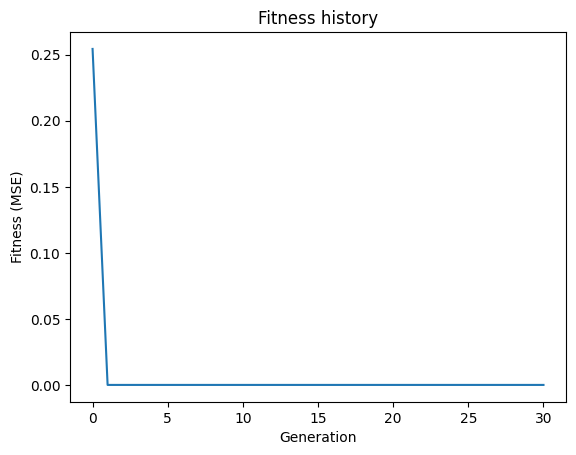

In [285]:
problem_id = 1
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variales:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(
                                                    initial_population, epochs_list[problem_id-1], X, y, variables,
                                                    max_depths[problem_id-1], cross_prob,
                                                    tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 2

Shape di X: (3, 5000)
Shape di y: (5000,)
Variales: ['x0', 'x1', 'x2']



Evolving Generations:   1%|          | 1/100 [00:08<14:50,  8.99s/it]

Generation 0: Best fitness = 29616224426136.594, Formula: (((sqrt(abs(x0)) * (abs(3.58) - -1.45)) ^ -8.19) + ((-9.95 / (sin(x1) + (x2 * -7.23))) * (((x2 / 6.58) - cos(-4.56)) * log(exp(x0)))))


Evolving Generations:   2%|▏         | 2/100 [00:18<14:59,  9.18s/it]

Generation 1: Best fitness = 29615284870485.703, Formula: (x2 / (sin(tan(x1)) - (sin(x0) * sin(x1))))


Evolving Generations:   3%|▎         | 3/100 [00:28<15:32,  9.61s/it]

Generation 2: Best fitness = 29615284870485.703, Formula: (x2 / (sin(tan(x1)) - (sin(x0) * sin(x1))))


Evolving Generations:   4%|▍         | 4/100 [00:37<15:18,  9.57s/it]

Generation 3: Best fitness = 29615284870485.703, Formula: (x2 / (sin(tan(x1)) - (sin(x0) * sin(x1))))


Evolving Generations:   5%|▌         | 5/100 [00:46<14:50,  9.37s/it]

Generation 4: Best fitness = 29604360154195.027, Formula: (x1 / (sqrt(x0) ^ sqrt((x2 / cos(4.67)))))


Evolving Generations:   6%|▌         | 6/100 [00:55<14:13,  9.08s/it]

Generation 5: Best fitness = 29604360154195.027, Formula: (x1 / (sqrt(x0) ^ sqrt((x2 / cos(4.67)))))


Evolving Generations:   7%|▋         | 7/100 [01:02<12:51,  8.30s/it]

Generation 6: Best fitness = 29604360154195.027, Formula: (x1 / (sqrt(x0) ^ sqrt((x2 / cos(4.67)))))


Evolving Generations:   8%|▊         | 8/100 [01:10<12:39,  8.26s/it]

Generation 7: Best fitness = 29604360154195.027, Formula: (x1 / (sqrt(x0) ^ sqrt((x2 / cos(4.67)))))


Evolving Generations:   9%|▉         | 9/100 [01:18<12:19,  8.13s/it]

Generation 8: Best fitness = 29604360154195.027, Formula: (x1 / (sqrt(x0) ^ sqrt((x2 / cos(4.67)))))


Evolving Generations:  10%|█         | 10/100 [01:27<12:43,  8.49s/it]

Generation 9: Best fitness = 29604360154195.027, Formula: (x1 / (sqrt(x0) ^ sqrt((x2 / cos(4.67)))))


Evolving Generations:  11%|█         | 11/100 [01:35<12:36,  8.50s/it]

Generation 10: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  12%|█▏        | 12/100 [01:43<12:08,  8.27s/it]

Generation 11: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  13%|█▎        | 13/100 [01:51<11:44,  8.10s/it]

Generation 12: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  14%|█▍        | 14/100 [02:00<12:10,  8.49s/it]

Generation 13: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  15%|█▌        | 15/100 [02:08<11:35,  8.18s/it]

Generation 14: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  16%|█▌        | 16/100 [02:15<11:04,  7.91s/it]

Generation 15: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  17%|█▋        | 17/100 [02:23<10:56,  7.91s/it]

Generation 16: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))
Regenerating population for diversity!


Evolving Generations:  18%|█▊        | 18/100 [02:32<11:03,  8.09s/it]

Generation 17: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  19%|█▉        | 19/100 [02:40<11:12,  8.31s/it]

Generation 18: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  20%|██        | 20/100 [02:49<11:09,  8.37s/it]

Generation 19: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  21%|██        | 21/100 [02:56<10:31,  7.99s/it]

Generation 20: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  22%|██▏       | 22/100 [03:03<10:02,  7.73s/it]

Generation 21: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  23%|██▎       | 23/100 [03:11<09:52,  7.70s/it]

Generation 22: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))
Regenerating population for diversity!


Evolving Generations:  24%|██▍       | 24/100 [03:18<09:33,  7.55s/it]

Generation 23: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  25%|██▌       | 25/100 [03:27<09:50,  7.87s/it]

Generation 24: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  26%|██▌       | 26/100 [03:33<09:18,  7.55s/it]

Generation 25: Best fitness = 29599804259876.75, Formula: (x0 / ((cos((-6.59 + sin(x2))) ^ log((tan(x1) - tan(-1.81)))) ^ 1.78))


Evolving Generations:  27%|██▋       | 27/100 [03:40<08:50,  7.26s/it]

Generation 26: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  28%|██▊       | 28/100 [03:46<08:20,  6.96s/it]

Generation 27: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  29%|██▉       | 29/100 [03:53<08:02,  6.80s/it]

Generation 28: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  30%|███       | 30/100 [03:59<07:38,  6.54s/it]

Generation 29: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  31%|███       | 31/100 [04:06<07:40,  6.68s/it]

Generation 30: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  32%|███▏      | 32/100 [04:12<07:20,  6.48s/it]

Generation 31: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  33%|███▎      | 33/100 [04:18<07:16,  6.52s/it]

Generation 32: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))
Regenerating population for diversity!


Evolving Generations:  34%|███▍      | 34/100 [04:25<07:22,  6.71s/it]

Generation 33: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  35%|███▌      | 35/100 [04:33<07:25,  6.86s/it]

Generation 34: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  36%|███▌      | 36/100 [04:39<07:15,  6.80s/it]

Generation 35: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  37%|███▋      | 37/100 [04:47<07:23,  7.04s/it]

Generation 36: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  38%|███▊      | 38/100 [04:54<07:12,  6.97s/it]

Generation 37: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  39%|███▉      | 39/100 [05:01<07:05,  6.98s/it]

Generation 38: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))
Regenerating population for diversity!


Evolving Generations:  40%|████      | 40/100 [05:08<07:03,  7.06s/it]

Generation 39: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  41%|████      | 41/100 [05:15<07:06,  7.23s/it]

Generation 40: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  42%|████▏     | 42/100 [05:22<06:49,  7.05s/it]

Generation 41: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  43%|████▎     | 43/100 [05:29<06:36,  6.96s/it]

Generation 42: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  44%|████▍     | 44/100 [05:35<06:21,  6.82s/it]

Generation 43: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  45%|████▌     | 45/100 [05:41<06:01,  6.58s/it]

Generation 44: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))
Regenerating population for diversity!


Evolving Generations:  46%|████▌     | 46/100 [05:50<06:22,  7.09s/it]

Generation 45: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  47%|████▋     | 47/100 [05:57<06:25,  7.28s/it]

Generation 46: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  48%|████▊     | 48/100 [06:05<06:29,  7.48s/it]

Generation 47: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  49%|████▉     | 49/100 [06:12<06:15,  7.35s/it]

Generation 48: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  50%|█████     | 50/100 [06:19<06:01,  7.24s/it]

Generation 49: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  51%|█████     | 51/100 [06:27<05:55,  7.26s/it]

Generation 50: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))
Regenerating population for diversity!


Evolving Generations:  52%|█████▏    | 52/100 [06:35<06:06,  7.63s/it]

Generation 51: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  53%|█████▎    | 53/100 [06:42<05:49,  7.45s/it]

Generation 52: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  54%|█████▍    | 54/100 [06:50<05:43,  7.46s/it]

Generation 53: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  55%|█████▌    | 55/100 [06:57<05:30,  7.34s/it]

Generation 54: Best fitness = 29483519488437.516, Formula: (x0 / (exp((x2 / x1)) ^ cos(exp(x1))))


Evolving Generations:  56%|█████▌    | 56/100 [07:04<05:19,  7.27s/it]

Generation 55: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  57%|█████▋    | 57/100 [07:11<05:08,  7.18s/it]

Generation 56: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  58%|█████▊    | 58/100 [07:17<04:46,  6.82s/it]

Generation 57: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  59%|█████▉    | 59/100 [07:24<04:45,  6.95s/it]

Generation 58: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  60%|██████    | 60/100 [07:31<04:34,  6.86s/it]

Generation 59: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  61%|██████    | 61/100 [07:38<04:38,  7.15s/it]

Generation 60: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  62%|██████▏   | 62/100 [07:46<04:37,  7.29s/it]

Generation 61: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Regenerating population for diversity!


Evolving Generations:  63%|██████▎   | 63/100 [07:52<04:18,  6.99s/it]

Generation 62: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  64%|██████▍   | 64/100 [08:00<04:16,  7.13s/it]

Generation 63: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  65%|██████▌   | 65/100 [08:08<04:17,  7.36s/it]

Generation 64: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  66%|██████▌   | 66/100 [08:16<04:15,  7.53s/it]

Generation 65: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  67%|██████▋   | 67/100 [08:24<04:12,  7.65s/it]

Generation 66: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  68%|██████▊   | 68/100 [08:30<03:52,  7.28s/it]

Generation 67: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Regenerating population for diversity!


Evolving Generations:  69%|██████▉   | 69/100 [08:37<03:44,  7.23s/it]

Generation 68: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  70%|███████   | 70/100 [08:45<03:40,  7.36s/it]

Generation 69: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  71%|███████   | 71/100 [08:52<03:32,  7.33s/it]

Generation 70: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  72%|███████▏  | 72/100 [09:00<03:30,  7.52s/it]

Generation 71: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  73%|███████▎  | 73/100 [09:08<03:25,  7.60s/it]

Generation 72: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  74%|███████▍  | 74/100 [09:17<03:30,  8.10s/it]

Generation 73: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Regenerating population for diversity!


Evolving Generations:  75%|███████▌  | 75/100 [09:25<03:18,  7.96s/it]

Generation 74: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  76%|███████▌  | 76/100 [09:34<03:22,  8.45s/it]

Generation 75: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  77%|███████▋  | 77/100 [09:42<03:08,  8.17s/it]

Generation 76: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  78%|███████▊  | 78/100 [09:48<02:48,  7.68s/it]

Generation 77: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  79%|███████▉  | 79/100 [09:54<02:25,  6.92s/it]

Generation 78: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  80%|████████  | 80/100 [10:00<02:13,  6.69s/it]

Generation 79: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Regenerating population for diversity!


Evolving Generations:  81%|████████  | 81/100 [10:07<02:08,  6.77s/it]

Generation 80: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  82%|████████▏ | 82/100 [10:15<02:12,  7.35s/it]

Generation 81: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  83%|████████▎ | 83/100 [10:22<02:01,  7.17s/it]

Generation 82: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  84%|████████▍ | 84/100 [10:29<01:52,  7.02s/it]

Generation 83: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  85%|████████▌ | 85/100 [10:35<01:40,  6.69s/it]

Generation 84: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  86%|████████▌ | 86/100 [10:41<01:31,  6.53s/it]

Generation 85: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  87%|████████▋ | 87/100 [10:49<01:29,  6.90s/it]

Generation 86: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  88%|████████▊ | 88/100 [11:00<01:40,  8.39s/it]

Generation 87: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  89%|████████▉ | 89/100 [11:10<01:35,  8.70s/it]

Generation 88: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  90%|█████████ | 90/100 [11:20<01:30,  9.06s/it]

Generation 89: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  91%|█████████ | 91/100 [11:28<01:18,  8.73s/it]

Generation 90: Best fitness = 29406704012808.23, Formula: (((exp((x2 + x0)) / sin((4.99 ^ x1))) + -12.32) / (1.11 ^ 2.48))


Evolving Generations:  92%|█████████▏| 92/100 [16:34<13:04, 98.05s/it]

Generation 91: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations:  93%|█████████▎| 93/100 [16:42<08:17, 71.10s/it]

Generation 92: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations:  94%|█████████▍| 94/100 [16:50<05:11, 51.92s/it]

Generation 93: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations:  95%|█████████▌| 95/100 [16:57<03:13, 38.69s/it]

Generation 94: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations:  96%|█████████▌| 96/100 [17:07<02:00, 30.08s/it]

Generation 95: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations:  97%|█████████▋| 97/100 [17:20<01:14, 24.92s/it]

Generation 96: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations:  98%|█████████▊| 98/100 [22:28<03:39, 109.86s/it]

Generation 97: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))
Regenerating population for diversity!


Evolving Generations:  99%|█████████▉| 99/100 [22:37<01:19, 79.49s/it] 

Generation 98: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))


Evolving Generations: 100%|██████████| 100/100 [22:45<00:00, 13.66s/it]

Generation 99: Best fitness = 29255618201714.156, Formula: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))

Best Formula found: ((x0 - (-7.77 - ((-5.87 + x1) - tan(-8.3)))) / exp((1.79 / (x2 + x0))))
Fitness: 29255618201714.156


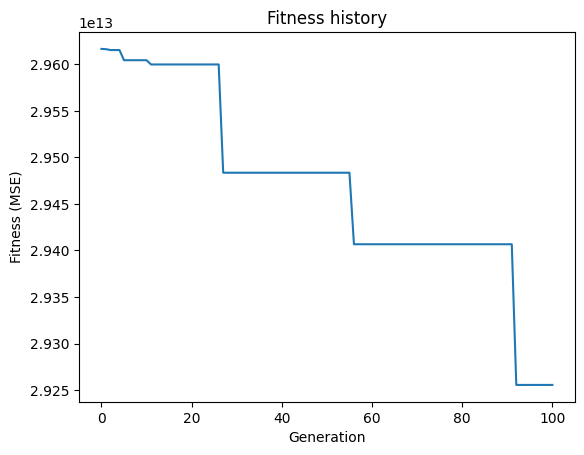

In [286]:
problem_id = 2
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variales:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables,
                                                    max_depths[problem_id-1], cross_prob,
                                                    tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 3

Shape di X: (3, 5000)
Shape di y: (5000,)
Variales: ['x0', 'x1', 'x2']



Evolving Generations:   1%|          | 1/100 [00:04<07:17,  4.42s/it]

Generation 0: Best fitness = 2724.7541179587656, Formula: ((tan(cos(x2)) ^ (-0.82 + (tan(x1) / -2.46))) / (cos((-3.57 / tan(x1))) / -10.7))


Evolving Generations:   2%|▏         | 2/100 [00:09<07:55,  4.85s/it]

Generation 1: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:   3%|▎         | 3/100 [00:14<07:42,  4.77s/it]

Generation 2: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:   4%|▍         | 4/100 [05:18<3:16:52, 123.05s/it]

Generation 3: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:   5%|▌         | 5/100 [05:24<2:08:05, 80.90s/it] 

Generation 4: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:   6%|▌         | 6/100 [05:28<1:25:47, 54.76s/it]

Generation 5: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:   7%|▋         | 7/100 [05:31<58:33, 37.77s/it]  

Generation 6: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:   8%|▊         | 8/100 [05:34<41:06, 26.81s/it]

Generation 7: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:   9%|▉         | 9/100 [05:38<29:30, 19.45s/it]

Generation 8: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  10%|█         | 10/100 [05:41<21:44, 14.49s/it]

Generation 9: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  11%|█         | 11/100 [05:45<16:28, 11.10s/it]

Generation 10: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  12%|█▏        | 12/100 [05:50<13:46,  9.39s/it]

Generation 11: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  13%|█▎        | 13/100 [05:54<11:09,  7.69s/it]

Generation 12: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  14%|█▍        | 14/100 [05:57<09:13,  6.44s/it]

Generation 13: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  15%|█▌        | 15/100 [06:02<08:12,  5.79s/it]

Generation 14: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  16%|█▌        | 16/100 [06:06<07:28,  5.33s/it]

Generation 15: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  17%|█▋        | 17/100 [06:10<06:43,  4.87s/it]

Generation 16: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  18%|█▊        | 18/100 [06:13<06:01,  4.40s/it]

Generation 17: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  19%|█▉        | 19/100 [06:17<05:45,  4.26s/it]

Generation 18: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  20%|██        | 20/100 [06:21<05:46,  4.33s/it]

Generation 19: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  21%|██        | 21/100 [06:25<05:32,  4.21s/it]

Generation 20: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  22%|██▏       | 22/100 [06:30<05:35,  4.30s/it]

Generation 21: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  23%|██▎       | 23/100 [06:34<05:37,  4.38s/it]

Generation 22: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  24%|██▍       | 24/100 [06:39<05:30,  4.36s/it]

Generation 23: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  25%|██▌       | 25/100 [06:43<05:23,  4.31s/it]

Generation 24: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  26%|██▌       | 26/100 [06:47<05:15,  4.27s/it]

Generation 25: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  27%|██▋       | 27/100 [06:51<05:06,  4.20s/it]

Generation 26: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  28%|██▊       | 28/100 [06:56<05:12,  4.34s/it]

Generation 27: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  29%|██▉       | 29/100 [07:00<05:06,  4.32s/it]

Generation 28: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  30%|███       | 30/100 [07:04<04:55,  4.23s/it]

Generation 29: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  31%|███       | 31/100 [07:08<04:43,  4.10s/it]

Generation 30: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  32%|███▏      | 32/100 [07:12<04:42,  4.16s/it]

Generation 31: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  33%|███▎      | 33/100 [07:17<04:45,  4.26s/it]

Generation 32: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  34%|███▍      | 34/100 [07:20<04:20,  3.95s/it]

Generation 33: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  35%|███▌      | 35/100 [07:24<04:26,  4.10s/it]

Generation 34: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  36%|███▌      | 36/100 [07:29<04:26,  4.16s/it]

Generation 35: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  37%|███▋      | 37/100 [07:33<04:18,  4.10s/it]

Generation 36: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  38%|███▊      | 38/100 [07:37<04:24,  4.26s/it]

Generation 37: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  39%|███▉      | 39/100 [07:41<04:17,  4.22s/it]

Generation 38: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  40%|████      | 40/100 [07:46<04:12,  4.21s/it]

Generation 39: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  41%|████      | 41/100 [07:50<04:07,  4.20s/it]

Generation 40: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  42%|████▏     | 42/100 [07:55<04:25,  4.58s/it]

Generation 41: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  43%|████▎     | 43/100 [07:59<04:09,  4.38s/it]

Generation 42: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  44%|████▍     | 44/100 [08:04<04:10,  4.47s/it]

Generation 43: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  45%|████▌     | 45/100 [08:08<04:02,  4.41s/it]

Generation 44: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  46%|████▌     | 46/100 [08:12<03:52,  4.31s/it]

Generation 45: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  47%|████▋     | 47/100 [08:16<03:45,  4.25s/it]

Generation 46: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  48%|████▊     | 48/100 [08:20<03:38,  4.19s/it]

Generation 47: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  49%|████▉     | 49/100 [08:24<03:29,  4.10s/it]

Generation 48: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  50%|█████     | 50/100 [08:28<03:25,  4.12s/it]

Generation 49: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  51%|█████     | 51/100 [08:33<03:26,  4.21s/it]

Generation 50: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  52%|█████▏    | 52/100 [08:38<03:29,  4.37s/it]

Generation 51: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  53%|█████▎    | 53/100 [08:42<03:22,  4.32s/it]

Generation 52: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  54%|█████▍    | 54/100 [08:45<03:08,  4.09s/it]

Generation 53: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  55%|█████▌    | 55/100 [08:49<03:01,  4.04s/it]

Generation 54: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  56%|█████▌    | 56/100 [13:52<1:08:39, 93.63s/it]

Generation 55: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Regenerating population for diversity!


Evolving Generations:  57%|█████▋    | 57/100 [13:55<47:34, 66.39s/it]  

Generation 56: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  58%|█████▊    | 58/100 [13:58<33:13, 47.46s/it]

Generation 57: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  59%|█████▉    | 59/100 [14:01<23:23, 34.24s/it]

Generation 58: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  60%|██████    | 60/100 [14:05<16:39, 24.98s/it]

Generation 59: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  61%|██████    | 61/100 [14:08<12:02, 18.54s/it]

Generation 60: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  62%|██████▏   | 62/100 [14:12<08:59, 14.19s/it]

Generation 61: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  63%|██████▎   | 63/100 [14:16<06:45, 10.96s/it]

Generation 62: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  64%|██████▍   | 64/100 [14:20<05:17,  8.81s/it]

Generation 63: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  65%|██████▌   | 65/100 [14:24<04:22,  7.51s/it]

Generation 64: Best fitness = 1906.0346384258721, Formula: ((sqrt(tan((5.63 + exp(x2)))) - (log((0.7 / x1)) * ((3.62 - x1) + (x0 - 1.71)))) * (sqrt(2.68) + 0.91))


Evolving Generations:  66%|██████▌   | 66/100 [14:29<03:49,  6.74s/it]

Generation 65: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  67%|██████▋   | 67/100 [14:35<03:34,  6.51s/it]

Generation 66: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  68%|██████▊   | 68/100 [14:40<03:19,  6.22s/it]

Generation 67: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  69%|██████▉   | 69/100 [14:44<02:51,  5.53s/it]

Generation 68: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  70%|███████   | 70/100 [14:48<02:30,  5.01s/it]

Generation 69: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  71%|███████   | 71/100 [14:52<02:14,  4.63s/it]

Generation 70: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  72%|███████▏  | 72/100 [14:57<02:09,  4.64s/it]

Generation 71: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Regenerating population for diversity!


Evolving Generations:  73%|███████▎  | 73/100 [15:02<02:09,  4.78s/it]

Generation 72: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  74%|███████▍  | 74/100 [15:07<02:07,  4.92s/it]

Generation 73: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  75%|███████▌  | 75/100 [15:12<02:02,  4.91s/it]

Generation 74: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  76%|███████▌  | 76/100 [20:15<37:47, 94.46s/it]

Generation 75: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  77%|███████▋  | 77/100 [20:20<25:50, 67.43s/it]

Generation 76: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  78%|███████▊  | 78/100 [20:23<17:41, 48.26s/it]

Generation 77: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Regenerating population for diversity!


Evolving Generations:  79%|███████▉  | 79/100 [20:27<12:12, 34.88s/it]

Generation 78: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  80%|████████  | 80/100 [20:31<08:31, 25.58s/it]

Generation 79: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  81%|████████  | 81/100 [20:33<05:55, 18.74s/it]

Generation 80: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  82%|████████▏ | 82/100 [20:37<04:14, 14.15s/it]

Generation 81: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  83%|████████▎ | 83/100 [20:41<03:07, 11.05s/it]

Generation 82: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  84%|████████▍ | 84/100 [20:45<02:22,  8.91s/it]

Generation 83: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Regenerating population for diversity!


Evolving Generations:  85%|████████▌ | 85/100 [20:50<01:56,  7.77s/it]

Generation 84: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  86%|████████▌ | 86/100 [20:54<01:35,  6.85s/it]

Generation 85: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  87%|████████▋ | 87/100 [20:59<01:18,  6.04s/it]

Generation 86: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  88%|████████▊ | 88/100 [26:01<18:57, 94.81s/it]

Generation 87: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  89%|████████▉ | 89/100 [26:04<12:22, 67.52s/it]

Generation 88: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  90%|█████████ | 90/100 [26:07<08:01, 48.15s/it]

Generation 89: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Regenerating population for diversity!


Evolving Generations:  91%|█████████ | 91/100 [26:10<05:11, 34.58s/it]

Generation 90: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  92%|█████████▏| 92/100 [26:14<03:21, 25.20s/it]

Generation 91: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  93%|█████████▎| 93/100 [26:18<02:12, 18.95s/it]

Generation 92: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  94%|█████████▍| 94/100 [26:22<01:26, 14.40s/it]

Generation 93: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  95%|█████████▌| 95/100 [26:25<00:56, 11.22s/it]

Generation 94: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  96%|█████████▌| 96/100 [26:29<00:35,  8.92s/it]

Generation 95: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  97%|█████████▋| 97/100 [26:34<00:22,  7.62s/it]

Generation 96: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  98%|█████████▊| 98/100 [26:39<00:13,  6.94s/it]

Generation 97: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations:  99%|█████████▉| 99/100 [26:45<00:06,  6.77s/it]

Generation 98: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)


Evolving Generations: 100%|██████████| 100/100 [31:50<00:00, 19.11s/it]

Generation 99: Best fitness = 1858.2448027781834, Formula: (((-9.46 * x1) + (-3.45 * x2)) + x1)

Best Formula found: (((-9.46 * x1) + (-3.45 * x2)) + x1)
Fitness: 1858.2448027781834


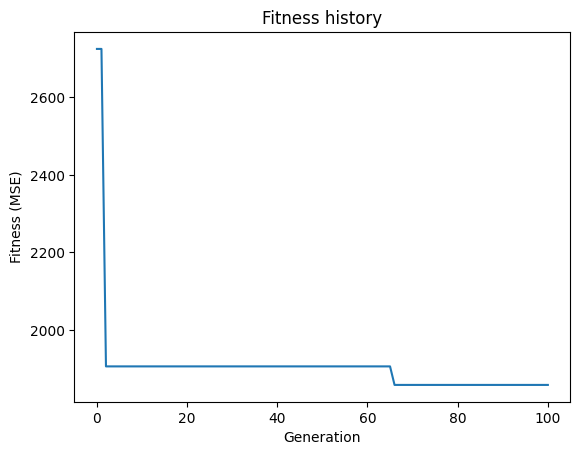

In [287]:
problem_id = 3
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variales:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables,
                                                    max_depths[problem_id-1], cross_prob,
                                                    tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 4

Shape di X: (2, 5000)
Shape di y: (5000,)
Variables: ['x0', 'x1']



Evolving Generations:   1%|          | 1/100 [00:05<08:42,  5.28s/it]

Generation 0: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))


Evolving Generations:   2%|▏         | 2/100 [00:11<09:11,  5.63s/it]

Generation 1: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))


Evolving Generations:   3%|▎         | 3/100 [00:16<08:51,  5.48s/it]

Generation 2: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))


Evolving Generations:   4%|▍         | 4/100 [00:21<08:35,  5.37s/it]

Generation 3: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))


Evolving Generations:   5%|▌         | 5/100 [00:27<08:46,  5.55s/it]

Generation 4: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))


Evolving Generations:   6%|▌         | 6/100 [00:34<09:18,  5.94s/it]

Generation 5: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))


Evolving Generations:   7%|▋         | 7/100 [00:41<09:45,  6.29s/it]

Generation 6: Best fitness = 21.733570524900074, Formula: (-6.31 / (sqrt((4.35 / (x1 - (sqrt(x0) - -5.59)))) * -3.5))
Regenerating population for diversity!


Evolving Generations:   8%|▊         | 8/100 [00:47<09:37,  6.27s/it]

Generation 7: Best fitness = 21.712131831664053, Formula: (sin((x1 * x1)) + exp((x0 * 0.17)))


Evolving Generations:   9%|▉         | 9/100 [00:53<09:15,  6.11s/it]

Generation 8: Best fitness = 21.41031069417495, Formula: cos(log((sqrt((x0 * 1.23)) * ((2.88 ^ x1) / abs(x0)))))


Evolving Generations:  10%|█         | 10/100 [00:58<08:39,  5.78s/it]

Generation 9: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  11%|█         | 11/100 [01:04<08:39,  5.84s/it]

Generation 10: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  12%|█▏        | 12/100 [01:09<08:20,  5.69s/it]

Generation 11: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  13%|█▎        | 13/100 [01:14<08:06,  5.59s/it]

Generation 12: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  14%|█▍        | 14/100 [01:21<08:19,  5.80s/it]

Generation 13: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  15%|█▌        | 15/100 [01:28<08:50,  6.24s/it]

Generation 14: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  16%|█▌        | 16/100 [01:33<08:22,  5.98s/it]

Generation 15: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))
Regenerating population for diversity!


Evolving Generations:  17%|█▋        | 17/100 [01:40<08:24,  6.08s/it]

Generation 16: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  18%|█▊        | 18/100 [01:46<08:17,  6.06s/it]

Generation 17: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  19%|█▉        | 19/100 [01:53<08:30,  6.30s/it]

Generation 18: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  20%|██        | 20/100 [01:59<08:25,  6.32s/it]

Generation 19: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  21%|██        | 21/100 [02:05<08:14,  6.26s/it]

Generation 20: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  22%|██▏       | 22/100 [02:10<07:38,  5.87s/it]

Generation 21: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))
Regenerating population for diversity!


Evolving Generations:  23%|██▎       | 23/100 [02:16<07:34,  5.91s/it]

Generation 22: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  24%|██▍       | 24/100 [02:22<07:38,  6.04s/it]

Generation 23: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  25%|██▌       | 25/100 [02:29<07:47,  6.23s/it]

Generation 24: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  26%|██▌       | 26/100 [02:36<08:06,  6.57s/it]

Generation 25: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  27%|██▋       | 27/100 [02:43<08:03,  6.62s/it]

Generation 26: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  28%|██▊       | 28/100 [02:50<08:07,  6.77s/it]

Generation 27: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))
Regenerating population for diversity!


Evolving Generations:  29%|██▉       | 29/100 [02:57<07:54,  6.68s/it]

Generation 28: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  30%|███       | 30/100 [03:04<07:59,  6.86s/it]

Generation 29: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  31%|███       | 31/100 [03:12<08:18,  7.22s/it]

Generation 30: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  32%|███▏      | 32/100 [03:18<07:48,  6.90s/it]

Generation 31: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  33%|███▎      | 33/100 [03:24<07:20,  6.58s/it]

Generation 32: Best fitness = 15.173378926673957, Formula: (abs((sin(cos(((x0 * x0) + log(x1)))) - 4.72)) * sin(cos(sqrt(x1))))


Evolving Generations:  34%|███▍      | 34/100 [03:30<06:52,  6.25s/it]

Generation 33: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  35%|███▌      | 35/100 [03:36<06:56,  6.41s/it]

Generation 34: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  36%|███▌      | 36/100 [03:45<07:26,  6.98s/it]

Generation 35: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  37%|███▋      | 37/100 [03:52<07:28,  7.12s/it]

Generation 36: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  38%|███▊      | 38/100 [04:00<07:33,  7.31s/it]

Generation 37: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  39%|███▉      | 39/100 [04:07<07:23,  7.27s/it]

Generation 38: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  40%|████      | 40/100 [04:14<07:16,  7.27s/it]

Generation 39: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  41%|████      | 41/100 [04:23<07:37,  7.76s/it]

Generation 40: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  42%|████▏     | 42/100 [04:30<07:14,  7.50s/it]

Generation 41: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  43%|████▎     | 43/100 [04:37<06:52,  7.23s/it]

Generation 42: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  44%|████▍     | 44/100 [04:44<06:40,  7.14s/it]

Generation 43: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  45%|████▌     | 45/100 [04:50<06:21,  6.93s/it]

Generation 44: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  46%|████▌     | 46/100 [04:57<06:20,  7.05s/it]

Generation 45: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  47%|████▋     | 47/100 [05:04<06:14,  7.07s/it]

Generation 46: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  48%|████▊     | 48/100 [05:12<06:08,  7.09s/it]

Generation 47: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  49%|████▉     | 49/100 [05:18<05:51,  6.88s/it]

Generation 48: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  50%|█████     | 50/100 [05:25<05:42,  6.85s/it]

Generation 49: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  51%|█████     | 51/100 [05:32<05:36,  6.87s/it]

Generation 50: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  52%|█████▏    | 52/100 [05:38<05:24,  6.76s/it]

Generation 51: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  53%|█████▎    | 53/100 [05:45<05:20,  6.81s/it]

Generation 52: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  54%|█████▍    | 54/100 [05:52<05:20,  6.96s/it]

Generation 53: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  55%|█████▌    | 55/100 [05:59<05:02,  6.72s/it]

Generation 54: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  56%|█████▌    | 56/100 [06:04<04:43,  6.45s/it]

Generation 55: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  57%|█████▋    | 57/100 [06:10<04:30,  6.29s/it]

Generation 56: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  58%|█████▊    | 58/100 [06:17<04:26,  6.34s/it]

Generation 57: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  59%|█████▉    | 59/100 [06:23<04:24,  6.45s/it]

Generation 58: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  60%|██████    | 60/100 [06:31<04:33,  6.83s/it]

Generation 59: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  61%|██████    | 61/100 [06:37<04:20,  6.67s/it]

Generation 60: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  62%|██████▏   | 62/100 [06:45<04:19,  6.83s/it]

Generation 61: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  63%|██████▎   | 63/100 [06:52<04:17,  6.97s/it]

Generation 62: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  64%|██████▍   | 64/100 [06:59<04:13,  7.05s/it]

Generation 63: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  65%|██████▌   | 65/100 [07:05<03:58,  6.80s/it]

Generation 64: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  66%|██████▌   | 66/100 [07:13<04:02,  7.13s/it]

Generation 65: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  67%|██████▋   | 67/100 [07:21<04:02,  7.35s/it]

Generation 66: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  68%|██████▊   | 68/100 [07:29<04:01,  7.55s/it]

Generation 67: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  69%|██████▉   | 69/100 [07:39<04:10,  8.09s/it]

Generation 68: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  70%|███████   | 70/100 [07:48<04:10,  8.36s/it]

Generation 69: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  71%|███████   | 71/100 [07:56<04:02,  8.35s/it]

Generation 70: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  72%|███████▏  | 72/100 [08:04<03:50,  8.22s/it]

Generation 71: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  73%|███████▎  | 73/100 [08:11<03:35,  7.99s/it]

Generation 72: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  74%|███████▍  | 74/100 [08:18<03:19,  7.69s/it]

Generation 73: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  75%|███████▌  | 75/100 [08:25<03:03,  7.33s/it]

Generation 74: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  76%|███████▌  | 76/100 [08:31<02:51,  7.15s/it]

Generation 75: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  77%|███████▋  | 77/100 [08:40<02:50,  7.42s/it]

Generation 76: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  78%|███████▊  | 78/100 [08:47<02:41,  7.32s/it]

Generation 77: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  79%|███████▉  | 79/100 [08:55<02:38,  7.55s/it]

Generation 78: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  80%|████████  | 80/100 [09:03<02:34,  7.74s/it]

Generation 79: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  81%|████████  | 81/100 [09:12<02:33,  8.10s/it]

Generation 80: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  82%|████████▏ | 82/100 [09:20<02:25,  8.10s/it]

Generation 81: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  83%|████████▎ | 83/100 [09:28<02:17,  8.09s/it]

Generation 82: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  84%|████████▍ | 84/100 [09:36<02:09,  8.09s/it]

Generation 83: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  85%|████████▌ | 85/100 [09:45<02:04,  8.33s/it]

Generation 84: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  86%|████████▌ | 86/100 [09:53<01:54,  8.19s/it]

Generation 85: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  87%|████████▋ | 87/100 [10:00<01:42,  7.86s/it]

Generation 86: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  88%|████████▊ | 88/100 [10:07<01:31,  7.66s/it]

Generation 87: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!


Evolving Generations:  89%|████████▉ | 89/100 [10:15<01:24,  7.68s/it]

Generation 88: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  90%|█████████ | 90/100 [10:22<01:13,  7.39s/it]

Generation 89: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  91%|█████████ | 91/100 [10:29<01:07,  7.50s/it]

Generation 90: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  92%|█████████▏| 92/100 [10:38<01:01,  7.72s/it]

Generation 91: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  93%|█████████▎| 93/100 [10:46<00:55,  7.94s/it]

Generation 92: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  94%|█████████▍| 94/100 [10:54<00:47,  7.84s/it]

Generation 93: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  95%|█████████▌| 95/100 [11:01<00:37,  7.56s/it]

Generation 94: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  96%|█████████▌| 96/100 [11:09<00:31,  7.78s/it]

Generation 95: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  97%|█████████▋| 97/100 [11:17<00:23,  7.81s/it]

Generation 96: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  98%|█████████▊| 98/100 [11:25<00:15,  7.83s/it]

Generation 97: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations:  99%|█████████▉| 99/100 [11:33<00:07,  7.89s/it]

Generation 98: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))


Evolving Generations: 100%|██████████| 100/100 [11:41<00:00,  7.01s/it]

Generation 99: Best fitness = 14.074100713713625, Formula: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Regenerating population for diversity!

Best Formula found: ((cos(abs(x1)) / 0.64) / ((sqrt(0.44) - exp(-2.25)) + (sin(x0) / 9.29)))
Fitness: 14.074100713713625


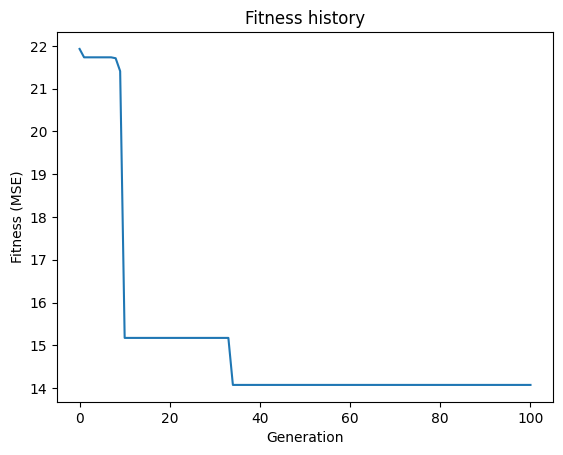

In [299]:
problem_id = 4
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variables:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables,
                                                    max_depths[problem_id-1], cross_prob,
                                                    tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 5

Shape di X: (2, 5000)
Shape di y: (5000,)
Variables: ['x0', 'x1']



Evolving Generations:   2%|▏         | 1/50 [00:02<01:41,  2.08s/it]

Generation 0: Best fitness = 0.050000004300411405, Formula: sqrt((exp((x1 + -7.93)) ^ 5.45))


Evolving Generations:   4%|▍         | 2/50 [00:04<01:38,  2.04s/it]

Generation 1: Best fitness = 0.05000000000000029, Formula: sin((exp((x1 + -7.93)) ^ 5.45))


Evolving Generations:   6%|▌         | 3/50 [00:06<01:42,  2.18s/it]

Generation 2: Best fitness = 0.05000000000000029, Formula: sin((exp((x1 + -7.93)) ^ 5.45))


Evolving Generations:   8%|▊         | 4/50 [00:08<01:44,  2.26s/it]

Generation 3: Best fitness = 0.05000000000000029, Formula: sin((exp((x1 + -7.93)) ^ 5.45))


Evolving Generations:  10%|█         | 5/50 [00:11<01:44,  2.32s/it]

Generation 4: Best fitness = 0.05000000000000029, Formula: sin((exp((x1 + -7.93)) ^ 5.45))


Evolving Generations:  12%|█▏        | 6/50 [00:14<01:54,  2.60s/it]

Generation 5: Best fitness = 0.05000000000000001, Formula: (((x1 - x1) / tan(3.94)) * log(sqrt(x1)))


Evolving Generations:  14%|█▍        | 7/50 [00:17<02:01,  2.82s/it]

Generation 6: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  16%|█▌        | 8/50 [00:21<02:16,  3.26s/it]

Generation 7: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  18%|█▊        | 9/50 [00:26<02:35,  3.80s/it]

Generation 8: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  20%|██        | 10/50 [00:31<02:47,  4.18s/it]

Generation 9: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  22%|██▏       | 11/50 [00:36<02:52,  4.41s/it]

Generation 10: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  24%|██▍       | 12/50 [00:41<02:52,  4.55s/it]

Generation 11: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  26%|██▌       | 13/50 [00:48<03:12,  5.20s/it]

Generation 12: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Regenerating population for diversity!


Evolving Generations:  28%|██▊       | 14/50 [00:54<03:15,  5.44s/it]

Generation 13: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  30%|███       | 15/50 [00:59<03:11,  5.48s/it]

Generation 14: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  32%|███▏      | 16/50 [01:06<03:13,  5.69s/it]

Generation 15: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  34%|███▍      | 17/50 [01:11<03:03,  5.57s/it]

Generation 16: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  36%|███▌      | 18/50 [01:16<02:51,  5.35s/it]

Generation 17: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  38%|███▊      | 19/50 [01:20<02:36,  5.06s/it]

Generation 18: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Regenerating population for diversity!


Evolving Generations:  40%|████      | 20/50 [01:25<02:30,  5.03s/it]

Generation 19: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  42%|████▏     | 21/50 [01:30<02:22,  4.90s/it]

Generation 20: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  44%|████▍     | 22/50 [01:35<02:18,  4.95s/it]

Generation 21: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  46%|████▌     | 23/50 [01:40<02:15,  5.00s/it]

Generation 22: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  48%|████▊     | 24/50 [01:45<02:07,  4.92s/it]

Generation 23: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  50%|█████     | 25/50 [01:50<02:06,  5.06s/it]

Generation 24: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Regenerating population for diversity!


Evolving Generations:  52%|█████▏    | 26/50 [01:56<02:06,  5.26s/it]

Generation 25: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  54%|█████▍    | 27/50 [02:00<01:56,  5.08s/it]

Generation 26: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  56%|█████▌    | 28/50 [02:05<01:45,  4.80s/it]

Generation 27: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  58%|█████▊    | 29/50 [02:09<01:35,  4.56s/it]

Generation 28: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  60%|██████    | 30/50 [02:12<01:26,  4.31s/it]

Generation 29: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  62%|██████▏   | 31/50 [02:16<01:19,  4.18s/it]

Generation 30: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Regenerating population for diversity!


Evolving Generations:  64%|██████▍   | 32/50 [02:21<01:16,  4.26s/it]

Generation 31: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  66%|██████▌   | 33/50 [02:25<01:12,  4.29s/it]

Generation 32: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  68%|██████▊   | 34/50 [02:30<01:12,  4.51s/it]

Generation 33: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  70%|███████   | 35/50 [02:35<01:10,  4.67s/it]

Generation 34: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  72%|███████▏  | 36/50 [02:40<01:07,  4.81s/it]

Generation 35: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  74%|███████▍  | 37/50 [02:45<01:02,  4.79s/it]

Generation 36: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  76%|███████▌  | 38/50 [02:49<00:54,  4.57s/it]

Generation 37: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  78%|███████▊  | 39/50 [02:54<00:51,  4.65s/it]

Generation 38: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  80%|████████  | 40/50 [02:59<00:49,  4.93s/it]

Generation 39: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  82%|████████▏ | 41/50 [03:05<00:46,  5.15s/it]

Generation 40: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  84%|████████▍ | 42/50 [03:12<00:44,  5.61s/it]

Generation 41: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  86%|████████▌ | 43/50 [03:18<00:40,  5.74s/it]

Generation 42: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Regenerating population for diversity!


Evolving Generations:  88%|████████▊ | 44/50 [03:24<00:34,  5.79s/it]

Generation 43: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  90%|█████████ | 45/50 [03:30<00:29,  5.87s/it]

Generation 44: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  92%|█████████▏| 46/50 [03:35<00:23,  5.79s/it]

Generation 45: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  94%|█████████▍| 47/50 [03:41<00:17,  5.77s/it]

Generation 46: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  96%|█████████▌| 48/50 [03:47<00:11,  5.73s/it]

Generation 47: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))


Evolving Generations:  98%|█████████▊| 49/50 [03:53<00:05,  5.79s/it]

Generation 48: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Regenerating population for diversity!


Evolving Generations: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it]

Generation 49: Best fitness = 5.572810232617333e-18, Formula: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))

Best Formula found: (((x1 - x1) / tan(3.94)) / ((8.52 - (-5.53 + log(7.59))) / x0))
Fitness: 5.572810232617333e-18


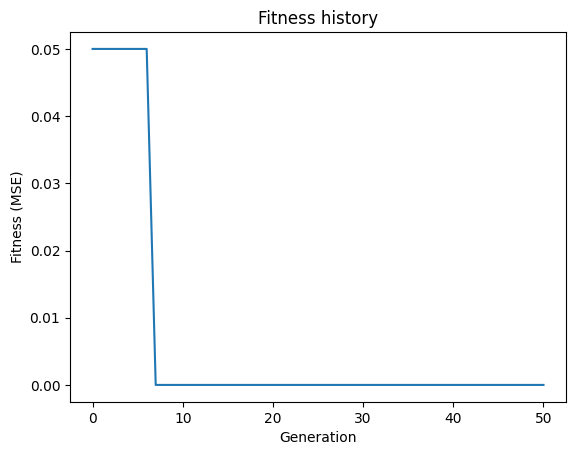

In [289]:
problem_id = 5
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variables:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables, 
                                                      max_depths[problem_id-1], cross_prob,
                                                      tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 6

Shape di X: (2, 5000)
Shape di y: (5000,)
Variables: ['x0', 'x1']



Evolving Generations:   1%|          | 1/100 [00:03<05:09,  3.12s/it]

Generation 0: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   2%|▏         | 2/100 [00:06<05:29,  3.36s/it]

Generation 1: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   3%|▎         | 3/100 [00:10<05:53,  3.65s/it]

Generation 2: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   4%|▍         | 4/100 [00:14<06:06,  3.82s/it]

Generation 3: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   5%|▌         | 5/100 [00:19<06:40,  4.22s/it]

Generation 4: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   6%|▌         | 6/100 [00:23<06:27,  4.12s/it]

Generation 5: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   7%|▋         | 7/100 [00:26<05:53,  3.80s/it]

Generation 6: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Regenerating population for diversity!


Evolving Generations:   8%|▊         | 8/100 [00:29<05:31,  3.60s/it]

Generation 7: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:   9%|▉         | 9/100 [00:33<05:22,  3.55s/it]

Generation 8: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  10%|█         | 10/100 [00:36<05:14,  3.50s/it]

Generation 9: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  11%|█         | 11/100 [00:39<04:50,  3.26s/it]

Generation 10: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  12%|█▏        | 12/100 [00:42<04:54,  3.35s/it]

Generation 11: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  13%|█▎        | 13/100 [00:45<04:38,  3.20s/it]

Generation 12: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Regenerating population for diversity!


Evolving Generations:  14%|█▍        | 14/100 [00:48<04:19,  3.02s/it]

Generation 13: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  15%|█▌        | 15/100 [00:51<04:06,  2.89s/it]

Generation 14: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  16%|█▌        | 16/100 [00:53<03:56,  2.81s/it]

Generation 15: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  17%|█▋        | 17/100 [00:56<04:02,  2.92s/it]

Generation 16: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  18%|█▊        | 18/100 [00:59<03:56,  2.88s/it]

Generation 17: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  19%|█▉        | 19/100 [01:01<03:35,  2.66s/it]

Generation 18: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Regenerating population for diversity!


Evolving Generations:  20%|██        | 20/100 [01:04<03:31,  2.64s/it]

Generation 19: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  21%|██        | 21/100 [01:06<03:22,  2.56s/it]

Generation 20: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  22%|██▏       | 22/100 [01:09<03:13,  2.48s/it]

Generation 21: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  23%|██▎       | 23/100 [01:11<03:08,  2.44s/it]

Generation 22: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  24%|██▍       | 24/100 [01:14<03:10,  2.51s/it]

Generation 23: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  25%|██▌       | 25/100 [01:16<03:07,  2.50s/it]

Generation 24: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Regenerating population for diversity!


Evolving Generations:  26%|██▌       | 26/100 [01:19<03:15,  2.64s/it]

Generation 25: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  27%|██▋       | 27/100 [01:23<03:46,  3.10s/it]

Generation 26: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  28%|██▊       | 28/100 [01:27<03:53,  3.24s/it]

Generation 27: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  29%|██▉       | 29/100 [01:30<03:47,  3.20s/it]

Generation 28: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  30%|███       | 30/100 [01:33<03:46,  3.23s/it]

Generation 29: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  31%|███       | 31/100 [01:36<03:35,  3.13s/it]

Generation 30: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  32%|███▏      | 32/100 [01:39<03:32,  3.13s/it]

Generation 31: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  33%|███▎      | 33/100 [01:42<03:15,  2.91s/it]

Generation 32: Best fitness = 3.1546773761143645, Formula: (-2.22 + (((x1 - -2.94) + -0.58) - (abs(x0) + sin(x1))))


Evolving Generations:  34%|███▍      | 34/100 [01:44<03:07,  2.83s/it]

Generation 33: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  35%|███▌      | 35/100 [01:48<03:15,  3.01s/it]

Generation 34: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  36%|███▌      | 36/100 [01:51<03:14,  3.04s/it]

Generation 35: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  37%|███▋      | 37/100 [01:54<03:07,  2.98s/it]

Generation 36: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  38%|███▊      | 38/100 [01:57<03:12,  3.10s/it]

Generation 37: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  39%|███▉      | 39/100 [02:00<03:11,  3.14s/it]

Generation 38: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  40%|████      | 40/100 [02:04<03:15,  3.26s/it]

Generation 39: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  41%|████      | 41/100 [02:08<03:37,  3.69s/it]

Generation 40: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  42%|████▏     | 42/100 [02:12<03:25,  3.54s/it]

Generation 41: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  43%|████▎     | 43/100 [02:14<03:09,  3.32s/it]

Generation 42: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  44%|████▍     | 44/100 [02:17<02:58,  3.18s/it]

Generation 43: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  45%|████▌     | 45/100 [02:20<02:48,  3.06s/it]

Generation 44: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  46%|████▌     | 46/100 [02:23<02:46,  3.09s/it]

Generation 45: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  47%|████▋     | 47/100 [02:26<02:37,  2.98s/it]

Generation 46: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  48%|████▊     | 48/100 [02:29<02:37,  3.03s/it]

Generation 47: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  49%|████▉     | 49/100 [02:33<02:44,  3.22s/it]

Generation 48: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  50%|█████     | 50/100 [02:37<02:51,  3.43s/it]

Generation 49: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  51%|█████     | 51/100 [02:40<02:43,  3.34s/it]

Generation 50: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  52%|█████▏    | 52/100 [02:43<02:43,  3.41s/it]

Generation 51: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  53%|█████▎    | 53/100 [02:47<02:47,  3.56s/it]

Generation 52: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  54%|█████▍    | 54/100 [02:52<02:54,  3.80s/it]

Generation 53: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  55%|█████▌    | 55/100 [02:56<02:57,  3.93s/it]

Generation 54: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  56%|█████▌    | 56/100 [02:59<02:40,  3.65s/it]

Generation 55: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  57%|█████▋    | 57/100 [03:02<02:27,  3.43s/it]

Generation 56: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  58%|█████▊    | 58/100 [03:05<02:15,  3.22s/it]

Generation 57: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  59%|█████▉    | 59/100 [03:07<02:02,  2.98s/it]

Generation 58: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  60%|██████    | 60/100 [03:10<02:01,  3.03s/it]

Generation 59: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  61%|██████    | 61/100 [03:14<02:04,  3.20s/it]

Generation 60: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  62%|██████▏   | 62/100 [03:18<02:09,  3.40s/it]

Generation 61: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  63%|██████▎   | 63/100 [03:21<02:06,  3.41s/it]

Generation 62: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  64%|██████▍   | 64/100 [03:25<02:08,  3.57s/it]

Generation 63: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  65%|██████▌   | 65/100 [03:30<02:18,  3.95s/it]

Generation 64: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  66%|██████▌   | 66/100 [03:35<02:25,  4.28s/it]

Generation 65: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  67%|██████▋   | 67/100 [03:39<02:16,  4.15s/it]

Generation 66: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  68%|██████▊   | 68/100 [03:42<02:08,  4.01s/it]

Generation 67: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  69%|██████▉   | 69/100 [03:46<01:58,  3.82s/it]

Generation 68: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  70%|███████   | 70/100 [03:49<01:53,  3.77s/it]

Generation 69: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  71%|███████   | 71/100 [03:54<01:54,  3.95s/it]

Generation 70: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  72%|███████▏  | 72/100 [03:58<01:51,  3.98s/it]

Generation 71: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  73%|███████▎  | 73/100 [04:01<01:44,  3.88s/it]

Generation 72: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  74%|███████▍  | 74/100 [04:04<01:33,  3.61s/it]

Generation 73: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  75%|███████▌  | 75/100 [04:08<01:30,  3.61s/it]

Generation 74: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  76%|███████▌  | 76/100 [04:11<01:24,  3.53s/it]

Generation 75: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  77%|███████▋  | 77/100 [04:15<01:22,  3.58s/it]

Generation 76: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  78%|███████▊  | 78/100 [04:19<01:21,  3.71s/it]

Generation 77: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  79%|███████▉  | 79/100 [04:23<01:18,  3.75s/it]

Generation 78: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  80%|████████  | 80/100 [04:26<01:12,  3.63s/it]

Generation 79: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  81%|████████  | 81/100 [04:31<01:13,  3.88s/it]

Generation 80: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  82%|████████▏ | 82/100 [04:35<01:11,  3.98s/it]

Generation 81: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  83%|████████▎ | 83/100 [04:39<01:06,  3.93s/it]

Generation 82: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  84%|████████▍ | 84/100 [04:43<01:02,  3.90s/it]

Generation 83: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  85%|████████▌ | 85/100 [04:47<01:00,  4.02s/it]

Generation 84: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  86%|████████▌ | 86/100 [04:51<00:55,  3.98s/it]

Generation 85: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  87%|████████▋ | 87/100 [04:54<00:50,  3.85s/it]

Generation 86: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  88%|████████▊ | 88/100 [04:58<00:47,  3.92s/it]

Generation 87: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!


Evolving Generations:  89%|████████▉ | 89/100 [05:02<00:42,  3.87s/it]

Generation 88: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  90%|█████████ | 90/100 [05:06<00:38,  3.81s/it]

Generation 89: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  91%|█████████ | 91/100 [05:09<00:32,  3.59s/it]

Generation 90: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  92%|█████████▏| 92/100 [05:12<00:28,  3.52s/it]

Generation 91: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  93%|█████████▎| 93/100 [05:16<00:26,  3.72s/it]

Generation 92: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  94%|█████████▍| 94/100 [05:21<00:23,  3.94s/it]

Generation 93: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  95%|█████████▌| 95/100 [05:25<00:19,  3.89s/it]

Generation 94: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  96%|█████████▌| 96/100 [05:29<00:15,  3.87s/it]

Generation 95: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  97%|█████████▋| 97/100 [05:31<00:10,  3.41s/it]

Generation 96: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  98%|█████████▊| 98/100 [05:34<00:06,  3.32s/it]

Generation 97: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations:  99%|█████████▉| 99/100 [05:38<00:03,  3.60s/it]

Generation 98: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))


Evolving Generations: 100%|██████████| 100/100 [05:42<00:00,  3.42s/it]

Generation 99: Best fitness = 2.5346321229997786, Formula: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Regenerating population for diversity!

Best Formula found: ((x1 + ((4.72 ^ -3.12) / exp(x0))) - abs(x0))
Fitness: 2.5346321229997786


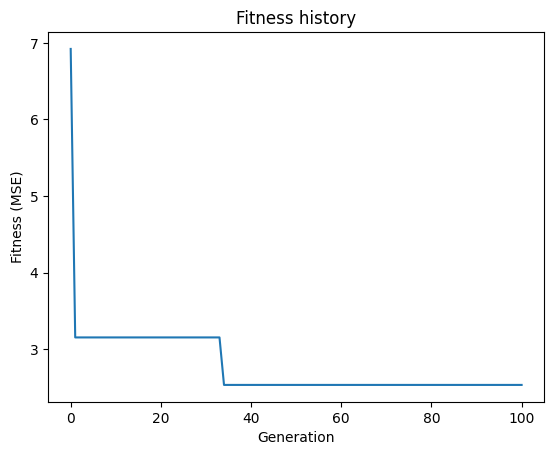

In [297]:
problem_id = 6
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variables:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables, 
                                                      max_depths[problem_id-1], cross_prob,
                                                      tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 7

Shape di X: (2, 5000)
Shape di y: (5000,)
Variables: ['x0', 'x1']



Evolving Generations:   1%|          | 1/100 [00:04<07:06,  4.31s/it]

Generation 0: Best fitness = 693.3043073458755, Formula: (((tan(abs((x1 ^ -8.0))) - (x1 / ((-9.32 * -4.41) / -1.6))) + -1.85) * 3.81)


Evolving Generations:   2%|▏         | 2/100 [00:07<06:03,  3.71s/it]

Generation 1: Best fitness = 693.3043073458755, Formula: (log(((log(2.75) * x1) ^ (x1 / tan(x0)))) - 1.8)


Evolving Generations:   3%|▎         | 3/100 [00:11<06:05,  3.77s/it]

Generation 2: Best fitness = 693.3043073458755, Formula: (((x0 * (2.13 * x1)) / (cos(x1) - (x1 / x1))) * 2.15)


Evolving Generations:   4%|▍         | 4/100 [00:15<06:06,  3.82s/it]

Generation 3: Best fitness = 693.3043073458755, Formula: (tan((abs(sqrt(sqrt(x1))) + 8.35)) + 3.82)


Evolving Generations:   5%|▌         | 5/100 [00:19<06:19,  4.00s/it]

Generation 4: Best fitness = 693.3043073458755, Formula: (tan((abs(sqrt(sqrt(x1))) + 8.35)) / 3.82)


Evolving Generations:   6%|▌         | 6/100 [00:24<06:41,  4.27s/it]

Generation 5: Best fitness = 693.3043073458755, Formula: (tan(cos(x0)) + 3.84)
Regenerating population for diversity!


Evolving Generations:   7%|▋         | 7/100 [00:28<06:41,  4.32s/it]

Generation 6: Best fitness = 693.3043073458755, Formula: (((-0.22 + x1) ^ 1.66) + 1.72)


Evolving Generations:   8%|▊         | 8/100 [00:32<06:24,  4.18s/it]

Generation 7: Best fitness = 664.610156690401, Formula: ((((x0 / 7.19) + (x0 * -6.93)) / (-3.21 / x1)) - -5.79)


Evolving Generations:   9%|▉         | 9/100 [00:37<06:40,  4.40s/it]

Generation 8: Best fitness = 594.1152232547691, Formula: (exp((x0 + x1)) ^ abs((sin(-4.67) - -0.34)))


Evolving Generations:  10%|█         | 10/100 [00:43<07:17,  4.86s/it]

Generation 9: Best fitness = 594.1152232547691, Formula: (exp((x0 + x1)) ^ abs((sin(-4.67) - -0.34)))


Evolving Generations:  11%|█         | 11/100 [00:49<07:30,  5.07s/it]

Generation 10: Best fitness = 594.1152232547691, Formula: (exp((x0 + x1)) ^ abs((sin(-4.67) - -0.34)))


Evolving Generations:  12%|█▏        | 12/100 [00:55<07:54,  5.39s/it]

Generation 11: Best fitness = 594.1152232547691, Formula: (exp((x0 + x1)) ^ abs((sin(-4.67) - -0.34)))


Evolving Generations:  13%|█▎        | 13/100 [01:00<07:50,  5.41s/it]

Generation 12: Best fitness = 594.1152232547691, Formula: (exp((x0 + x1)) ^ abs((sin(-4.67) - -0.34)))


Evolving Generations:  14%|█▍        | 14/100 [01:04<07:14,  5.05s/it]

Generation 13: Best fitness = 594.1152232547691, Formula: (exp((x0 + x1)) ^ abs((sin(-4.67) - -0.34)))


Evolving Generations:  15%|█▌        | 15/100 [01:08<06:44,  4.76s/it]

Generation 14: Best fitness = 401.44675121465457, Formula: (1.47 + exp((abs(x0) + (x0 * x1))))


Evolving Generations:  16%|█▌        | 16/100 [01:13<06:33,  4.68s/it]

Generation 15: Best fitness = 401.44675121465457, Formula: (1.47 + exp((abs(x0) + (x0 * x1))))


Evolving Generations:  17%|█▋        | 17/100 [01:18<06:41,  4.83s/it]

Generation 16: Best fitness = 401.44675121465457, Formula: (1.47 + exp((abs(x0) + (x0 * x1))))


Evolving Generations:  18%|█▊        | 18/100 [01:25<07:19,  5.35s/it]

Generation 17: Best fitness = 401.44675121465457, Formula: (1.47 + exp((abs(x0) + (x0 * x1))))


Evolving Generations:  19%|█▉        | 19/100 [01:31<07:47,  5.77s/it]

Generation 18: Best fitness = 400.3178044066751, Formula: (sin(log(sqrt(sqrt((-3.98 + 5.03))))) + exp((abs(x0) + (x0 * x1))))


Evolving Generations:  20%|██        | 20/100 [01:38<08:06,  6.08s/it]

Generation 19: Best fitness = 395.1114919152147, Formula: (exp((abs(x0) + (x0 * x1))) - (exp(x0) * x0))


Evolving Generations:  21%|██        | 21/100 [01:44<08:02,  6.11s/it]

Generation 20: Best fitness = 395.1114919152147, Formula: (exp((abs(x0) + (x0 * x1))) - (exp(x0) * x0))


Evolving Generations:  22%|██▏       | 22/100 [01:51<08:02,  6.19s/it]

Generation 21: Best fitness = 395.1114919152147, Formula: (exp((abs(x0) + (x0 * x1))) - (exp(x0) * x0))


Evolving Generations:  23%|██▎       | 23/100 [01:57<08:03,  6.28s/it]

Generation 22: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  24%|██▍       | 24/100 [02:04<08:08,  6.42s/it]

Generation 23: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  25%|██▌       | 25/100 [02:10<07:42,  6.17s/it]

Generation 24: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  26%|██▌       | 26/100 [02:16<07:46,  6.31s/it]

Generation 25: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  27%|██▋       | 27/100 [02:23<07:44,  6.36s/it]

Generation 26: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  28%|██▊       | 28/100 [02:31<08:10,  6.81s/it]

Generation 27: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  29%|██▉       | 29/100 [02:39<08:31,  7.20s/it]

Generation 28: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  30%|███       | 30/100 [02:47<08:45,  7.50s/it]

Generation 29: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  31%|███       | 31/100 [02:53<08:16,  7.19s/it]

Generation 30: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  32%|███▏      | 32/100 [03:00<07:47,  6.88s/it]

Generation 31: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  33%|███▎      | 33/100 [03:06<07:29,  6.70s/it]

Generation 32: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  34%|███▍      | 34/100 [03:12<07:10,  6.52s/it]

Generation 33: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  35%|███▌      | 35/100 [03:18<06:57,  6.43s/it]

Generation 34: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  36%|███▌      | 36/100 [03:25<06:58,  6.53s/it]

Generation 35: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  37%|███▋      | 37/100 [03:32<06:52,  6.55s/it]

Generation 36: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  38%|███▊      | 38/100 [03:39<06:58,  6.74s/it]

Generation 37: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  39%|███▉      | 39/100 [03:45<06:50,  6.74s/it]

Generation 38: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  40%|████      | 40/100 [03:52<06:35,  6.59s/it]

Generation 39: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  41%|████      | 41/100 [03:58<06:24,  6.52s/it]

Generation 40: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  42%|████▏     | 42/100 [04:04<06:11,  6.41s/it]

Generation 41: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  43%|████▎     | 43/100 [04:10<05:55,  6.24s/it]

Generation 42: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  44%|████▍     | 44/100 [04:16<05:39,  6.06s/it]

Generation 43: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  45%|████▌     | 45/100 [04:22<05:33,  6.07s/it]

Generation 44: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  46%|████▌     | 46/100 [04:28<05:25,  6.03s/it]

Generation 45: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  47%|████▋     | 47/100 [04:35<05:33,  6.29s/it]

Generation 46: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  48%|████▊     | 48/100 [04:41<05:32,  6.40s/it]

Generation 47: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  49%|████▉     | 49/100 [04:48<05:29,  6.45s/it]

Generation 48: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  50%|█████     | 50/100 [04:54<05:20,  6.41s/it]

Generation 49: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  51%|█████     | 51/100 [05:02<05:31,  6.77s/it]

Generation 50: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  52%|█████▏    | 52/100 [05:09<05:25,  6.79s/it]

Generation 51: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  53%|█████▎    | 53/100 [05:15<05:14,  6.70s/it]

Generation 52: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  54%|█████▍    | 54/100 [05:21<05:01,  6.56s/it]

Generation 53: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  55%|█████▌    | 55/100 [05:27<04:49,  6.43s/it]

Generation 54: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  56%|█████▌    | 56/100 [05:34<04:39,  6.35s/it]

Generation 55: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  57%|█████▋    | 57/100 [05:41<04:41,  6.54s/it]

Generation 56: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  58%|█████▊    | 58/100 [05:47<04:31,  6.46s/it]

Generation 57: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  59%|█████▉    | 59/100 [05:54<04:27,  6.53s/it]

Generation 58: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  60%|██████    | 60/100 [05:59<04:14,  6.35s/it]

Generation 59: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  61%|██████    | 61/100 [06:06<04:12,  6.47s/it]

Generation 60: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  62%|██████▏   | 62/100 [06:13<04:12,  6.64s/it]

Generation 61: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  63%|██████▎   | 63/100 [06:21<04:13,  6.84s/it]

Generation 62: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  64%|██████▍   | 64/100 [06:27<03:56,  6.58s/it]

Generation 63: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  65%|██████▌   | 65/100 [06:32<03:42,  6.36s/it]

Generation 64: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  66%|██████▌   | 66/100 [06:39<03:40,  6.48s/it]

Generation 65: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  67%|██████▋   | 67/100 [06:46<03:33,  6.47s/it]

Generation 66: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  68%|██████▊   | 68/100 [06:53<03:39,  6.86s/it]

Generation 67: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  69%|██████▉   | 69/100 [07:01<03:41,  7.15s/it]

Generation 68: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  70%|███████   | 70/100 [07:09<03:41,  7.39s/it]

Generation 69: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  71%|███████   | 71/100 [07:17<03:41,  7.63s/it]

Generation 70: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  72%|███████▏  | 72/100 [07:24<03:29,  7.49s/it]

Generation 71: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  73%|███████▎  | 73/100 [07:31<03:16,  7.27s/it]

Generation 72: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  74%|███████▍  | 74/100 [07:38<03:04,  7.11s/it]

Generation 73: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  75%|███████▌  | 75/100 [07:45<02:58,  7.16s/it]

Generation 74: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  76%|███████▌  | 76/100 [07:52<02:46,  6.93s/it]

Generation 75: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  77%|███████▋  | 77/100 [07:59<02:42,  7.04s/it]

Generation 76: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  78%|███████▊  | 78/100 [08:06<02:35,  7.07s/it]

Generation 77: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  79%|███████▉  | 79/100 [08:13<02:28,  7.08s/it]

Generation 78: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  80%|████████  | 80/100 [08:21<02:23,  7.16s/it]

Generation 79: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  81%|████████  | 81/100 [08:28<02:20,  7.38s/it]

Generation 80: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  82%|████████▏ | 82/100 [08:35<02:11,  7.28s/it]

Generation 81: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  83%|████████▎ | 83/100 [08:44<02:07,  7.51s/it]

Generation 82: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation
Regenerating population for diversity!


Evolving Generations:  84%|████████▍ | 84/100 [08:52<02:05,  7.85s/it]

Generation 83: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  85%|████████▌ | 85/100 [09:00<01:59,  7.99s/it]

Generation 84: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  86%|████████▌ | 86/100 [09:08<01:50,  7.91s/it]

Generation 85: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  87%|████████▋ | 87/100 [09:15<01:40,  7.70s/it]

Generation 86: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  88%|████████▊ | 88/100 [09:23<01:31,  7.61s/it]

Generation 87: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  89%|████████▉ | 89/100 [09:31<01:24,  7.69s/it]

Generation 88: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  90%|█████████ | 90/100 [09:38<01:16,  7.69s/it]

Generation 89: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  91%|█████████ | 91/100 [09:48<01:13,  8.19s/it]

Generation 90: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  92%|█████████▏| 92/100 [09:55<01:04,  8.01s/it]

Generation 91: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  93%|█████████▎| 93/100 [10:03<00:54,  7.76s/it]

Generation 92: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  94%|█████████▍| 94/100 [10:09<00:44,  7.45s/it]

Generation 93: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  95%|█████████▌| 95/100 [10:16<00:36,  7.38s/it]

Generation 94: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Regenerating population for diversity!


Evolving Generations:  96%|█████████▌| 96/100 [10:24<00:29,  7.44s/it]

Generation 95: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  97%|█████████▋| 97/100 [10:31<00:21,  7.33s/it]

Generation 96: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  98%|█████████▊| 98/100 [10:37<00:13,  6.94s/it]

Generation 97: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations:  99%|█████████▉| 99/100 [10:45<00:07,  7.30s/it]

Generation 98: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))


Evolving Generations: 100%|██████████| 100/100 [10:53<00:00,  6.54s/it]

Generation 99: Best fitness = 357.52091727544365, Formula: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))

Best Formula found: (exp((abs(x0) + (x0 * x1))) * exp((abs(x0) / -8.88)))
Fitness: 357.52091727544365


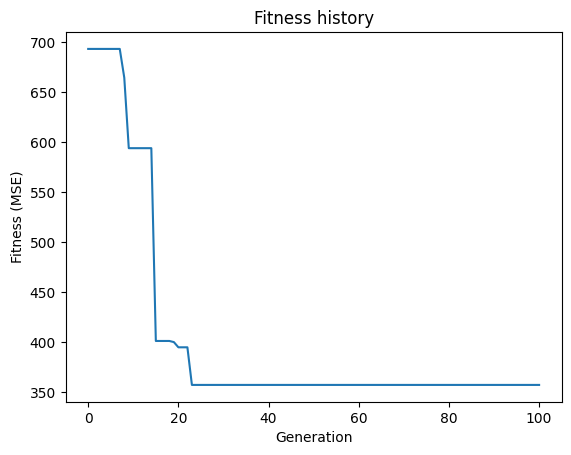

In [291]:
problem_id = 7
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variables:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables, 
                                                      max_depths[problem_id-1], cross_prob,
                                                      tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()

## Problem 8

Shape di X: (6, 50000)
Shape di y: (50000,)
Variables: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']



Evolving Generations:   2%|▏         | 1/50 [00:44<36:23, 44.55s/it]

Generation 0: Best fitness = 23508156.351110194, Formula: tan((sqrt(((x3 - x2) + 7.53)) + (log((-3.64 + x5)) - log(x3))))


Evolving Generations:   4%|▍         | 2/50 [01:32<37:01, 46.28s/it]

Generation 1: Best fitness = 23007781.93803824, Formula: ((((x1 - x5) - (x3 - x2)) + cos(x0)) * tan(sin((x4 * x1))))


Evolving Generations:   6%|▌         | 3/50 [02:21<37:28, 47.83s/it]

Generation 2: Best fitness = 23007781.93803824, Formula: ((((x1 - x5) - (x3 - x2)) + cos(x0)) * tan(sin((x4 * x1))))


Evolving Generations:   8%|▊         | 4/50 [03:20<40:00, 52.18s/it]

Generation 3: Best fitness = 23007781.93803824, Formula: ((((x1 - x5) - (x3 - x2)) + cos(x0)) * tan(sin((x4 * x1))))


Evolving Generations:  10%|█         | 5/50 [04:19<40:54, 54.54s/it]

Generation 4: Best fitness = 22988094.06260685, Formula: (log(tan(log(x4))) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  12%|█▏        | 6/50 [05:15<40:19, 54.98s/it]

Generation 5: Best fitness = 22988094.06260685, Formula: (log(tan(log(x4))) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  14%|█▍        | 7/50 [06:11<39:39, 55.33s/it]

Generation 6: Best fitness = 22988094.06260685, Formula: (log(tan(log(x4))) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  16%|█▌        | 8/50 [07:10<39:42, 56.72s/it]

Generation 7: Best fitness = 22988094.06260685, Formula: (log(tan(log(x4))) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  18%|█▊        | 9/50 [08:10<39:17, 57.49s/it]

Generation 8: Best fitness = 22988094.06260685, Formula: (log(tan(log(x4))) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  20%|██        | 10/50 [09:14<39:40, 59.51s/it]

Generation 9: Best fitness = 22988094.06260685, Formula: (log(tan(log(x4))) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  22%|██▏       | 11/50 [10:16<39:20, 60.52s/it]

Generation 10: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  24%|██▍       | 12/50 [11:05<35:56, 56.76s/it]

Generation 11: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  26%|██▌       | 13/50 [12:01<34:51, 56.53s/it]

Generation 12: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  28%|██▊       | 14/50 [12:49<32:28, 54.12s/it]

Generation 13: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  30%|███       | 15/50 [13:53<33:22, 57.21s/it]

Generation 14: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  32%|███▏      | 16/50 [15:01<34:09, 60.28s/it]

Generation 15: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  34%|███▍      | 17/50 [15:59<32:51, 59.75s/it]

Generation 16: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))
Regenerating population for diversity!


Evolving Generations:  36%|███▌      | 18/50 [16:58<31:45, 59.54s/it]

Generation 17: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  38%|███▊      | 19/50 [17:52<29:47, 57.68s/it]

Generation 18: Best fitness = 22985103.3508561, Formula: (cos(x4) - (((x1 - x5) - (x3 - x2)) + cos(x0)))


Evolving Generations:  40%|████      | 20/50 [18:42<27:43, 55.44s/it]

Generation 19: Best fitness = 16554050.559054743, Formula: (exp((x5 - -4.16)) + exp(cos(x0)))


Evolving Generations:  42%|████▏     | 21/50 [19:28<25:26, 52.65s/it]

Generation 20: Best fitness = 16554050.559054743, Formula: (exp((x5 - -4.16)) + exp(cos(x0)))


Evolving Generations:  44%|████▍     | 22/50 [20:06<22:25, 48.06s/it]

Generation 21: Best fitness = 16111953.480767574, Formula: (exp((x5 - -4.16)) - exp((x2 + abs(-3.06))))


Evolving Generations:  46%|████▌     | 23/50 [20:44<20:19, 45.17s/it]

Generation 22: Best fitness = 16111953.480767574, Formula: (exp((x5 - -4.16)) - exp((x2 + abs(-3.06))))


Evolving Generations:  48%|████▊     | 24/50 [21:28<19:26, 44.87s/it]

Generation 23: Best fitness = 16111953.480767574, Formula: (exp((x5 - -4.16)) - exp((x2 + abs(-3.06))))


Evolving Generations:  50%|█████     | 25/50 [22:15<18:55, 45.44s/it]

Generation 24: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  52%|█████▏    | 26/50 [22:56<17:36, 44.03s/it]

Generation 25: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  54%|█████▍    | 27/50 [23:38<16:44, 43.67s/it]

Generation 26: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  56%|█████▌    | 28/50 [24:28<16:36, 45.29s/it]

Generation 27: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  58%|█████▊    | 29/50 [25:24<16:59, 48.53s/it]

Generation 28: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  60%|██████    | 30/50 [26:22<17:06, 51.35s/it]

Generation 29: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  62%|██████▏   | 31/50 [27:20<16:56, 53.52s/it]

Generation 30: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Regenerating population for diversity!


Evolving Generations:  64%|██████▍   | 32/50 [28:05<15:16, 50.93s/it]

Generation 31: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  66%|██████▌   | 33/50 [29:03<15:02, 53.10s/it]

Generation 32: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  68%|██████▊   | 34/50 [30:03<14:42, 55.13s/it]

Generation 33: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  70%|███████   | 35/50 [31:00<13:56, 55.77s/it]

Generation 34: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  72%|███████▏  | 36/50 [32:10<13:57, 59.81s/it]

Generation 35: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  74%|███████▍  | 37/50 [33:06<12:43, 58.74s/it]

Generation 36: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Regenerating population for diversity!


Evolving Generations:  76%|███████▌  | 38/50 [34:07<11:53, 59.45s/it]

Generation 37: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  78%|███████▊  | 39/50 [35:01<10:36, 57.84s/it]

Generation 38: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  80%|████████  | 40/50 [35:55<09:27, 56.76s/it]

Generation 39: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  82%|████████▏ | 41/50 [36:52<08:30, 56.77s/it]

Generation 40: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  84%|████████▍ | 42/50 [37:54<07:47, 58.42s/it]

Generation 41: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  86%|████████▌ | 43/50 [38:49<06:40, 57.27s/it]

Generation 42: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Regenerating population for diversity!


Evolving Generations:  88%|████████▊ | 44/50 [39:37<05:28, 54.67s/it]

Generation 43: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  90%|█████████ | 45/50 [40:32<04:32, 54.48s/it]

Generation 44: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Adapting parameters: Less Crossover = 0.6499999999999999, more mutation


Evolving Generations:  92%|█████████▏| 46/50 [41:24<03:35, 53.85s/it]

Generation 45: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  94%|█████████▍| 47/50 [42:15<02:39, 53.16s/it]

Generation 46: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  96%|█████████▌| 48/50 [43:06<01:44, 52.47s/it]

Generation 47: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))


Evolving Generations:  98%|█████████▊| 49/50 [43:47<00:49, 49.04s/it]

Generation 48: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Regenerating population for diversity!


Evolving Generations: 100%|██████████| 50/50 [44:40<00:00, 53.62s/it]

Generation 49: Best fitness = 16107278.993818918, Formula: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))

Best Formula found: (exp((x5 - -4.16)) + tan((cos(x3) + tan(x4))))
Fitness: 16107278.993818918


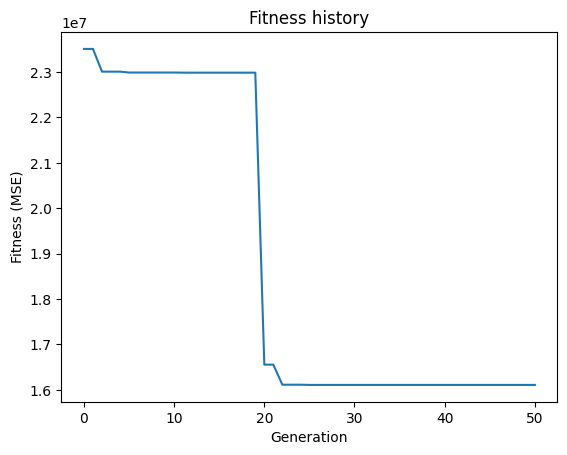

In [307]:
problem_id = 8
data = np.load(f"data/problem_{problem_id}.npz")
X = data['x']
y = data['y']

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

num_vars = X.shape[0]
variables = [f"x{i}" for i in range(num_vars)]
print("Variables:", variables)
print()

initial_population = generate_population(pop_sizes[problem_id-1], max_depths[problem_id-1], variables)
best_formula, best_fitness, fitness_history  = evolve(initial_population, epochs_list[problem_id-1], X, y, variables, 
                                                      max_depths[problem_id-1], cross_prob,
                                                      tournament_sizes[problem_id-1], penalties[problem_id-1])

print()
print(f"Best Formula found: {best_formula.to_formula()}")
print(f"Fitness: {best_fitness}")
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.title("Fitness history")
plt.show()